# Install packages

In [46]:
###
###
# install requirements
###
###

# Import packages

In [315]:
import random
import numpy as np
import pandas as pd
import re
import tqdm
import itertools
from nltk import FreqDist

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from hazm import Normalizer, Stemmer, Lemmatizer
from hazm import WordTokenizer, SentenceTokenizer, word_tokenize
import emoji

# Data loading

In [364]:
tehran_posts = pd.read_csv('data/tehran-apartment-sell-posts.csv')
mashhad_posts = pd.read_csv('data/mashhad-apartment-sell-posts.csv')
isfahan_posts = pd.read_csv('data/isfahan-apartment-sell-posts.csv')
ardabil_posts = pd.read_csv('data/ardabil-apartment-sell-posts.csv')
tabriz_posts = pd.read_csv('data/tabriz-apartment-sell-posts.csv')
shiraz_posts = pd.read_csv('data/shiraz-apartment-sell-posts.csv')

In [366]:
tehran_posts['city'] = 'tehran'
mashhad_posts['city'] = 'mashhad'
isfahan_posts['city'] = 'isfahan'
ardabil_posts['city'] = 'ardabil'
tabriz_posts['city'] = 'tabriz'
shiraz_posts['city'] = 'shiraz'

In [367]:
posts = pd.concat([tehran_posts, mashhad_posts, isfahan_posts, ardabil_posts, tabriz_posts, shiraz_posts], ignore_index=True)

# Clean data

In [368]:
posts.head()

,Area,Construction,Room,Warehouse,Parking,Elevator,Address,Price,Description,city
0,63,1375,1,False,False,True,دقایقی پیش در تهران، شمشیری، خیابان شمشیری (ب....,۱٬۶۰۰٬۰۰۰٬۰۰۰ تومان,"<p class=""kt-description-row__text kt-descript...",tehran
1,180,1393,3,True,True,True,دقایقی پیش در تهران، شیان | فروش آپارتمان,۱۴٬۰۰۰٬۰۰۰٬۰۰۰ تومان,"<p class=""kt-description-row__text kt-descript...",tehran
2,38,1380,1,False,False,True,دقایقی پیش در تهران، پلیس | فروش آپارتمان,۱٬۳۸۰٬۰۰۰٬۰۰۰ تومان,"<p class=""kt-description-row__text kt-descript...",tehran
3,88,1384,2,True,True,True,دقایقی پیش در تهران، تهران‌نو | فروش آپارتمان,۳٬۵۰۰٬۰۰۰٬۰۰۰ تومان,"<p class=""kt-description-row__text kt-descript...",tehran
4,40,1393,1,True,True,True,دقایقی پیش در تهران، بریانک | فروش آپارتمان,۱٬۴۲۰٬۰۰۰٬۰۰۰ تومان,"<p class=""kt-description-row__text kt-descript...",tehran


In [369]:
posts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Area          3169 non-null   object
 1   Construction  3169 non-null   object
 2   Room          3169 non-null   object
 3   Warehouse     3169 non-null   object
 4   Parking       3169 non-null   object
 5   Elevator      3169 non-null   object
 6   Address       3169 non-null   object
 7   Price         3169 non-null   object
 8   Description   3169 non-null   object
 9   city          3169 non-null   object
dtypes: object(10)
memory usage: 247.7+ KB


In [375]:
for desc in random.sample(list(posts.Description.values), 5):
    print(desc)
    print('#'*100)

<p class="kt-description-row__text kt-description-row__text--primary">✅۵ طبقه ۱۵ واحد 
✅طبقه اول گرمایش از کف 
✅موقعیت مکانی فوق العاده عالی 
✅سرامیک
✅ کابینت چوب 
✅۲خواب یک خواب مستر 
✅تراس بزرگ
✅نورگیر ۲ نبش 
✅مشاعات و فیلتر ها تمام سنگ 
✅پارکینگ و انباری اختصاصی 
✅کاغذ دیواری ترکیبی 
✅گاز رو کار و هود لمسی 
✅سرویس ایرانی و فرنگی 
✅کمد دیواری چوب و جادار
✅قابلیت رهن تا ۵۰۰ میلیون 
✅دفتر نبش سجادیه ۱۷ مسکن فراز 
☑همکاران محترم تماس نفرمایید ☑
مشاور شما علیزاده</p>
####################################################################################################
<p class="kt-description-row__text kt-description-row__text--primary">بنام خدا

۶۰ متر تکخواب / ۳ تا پله  به پایین

سالن مربع و بزرگ / بسیار خوش نقش 

          " بدون کوچکترین پرتی "

حیاط اختصاصی قابل استفاده فقط برای این واحد ✅
گذر عالی و پهن با دسترسی فوق‌العاده ✅
مختص سخت پسندان منطقه ✅
مناسب برای سرمایه گذاری ✅
زیر قیمت منطقه ✅

♦️ املاک بزرگ متین ♦️
مشاور تخصصی منطقه= کشاورز</p>
########################################

### Clean Address feature

In [377]:
posts.Address[0]

'دقایقی پیش در تهران، شمشیری، خیابان شمشیری (ب. ایت الله سعیدی) | فروش آپارتمان'

In [378]:
class extractAddressTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X.Address = X.Address.apply(
            lambda adress: '،'.join(adress.split('|')[0].split('،')[1:])
        )
        return X

In [323]:
t = extractAddressTransformer()

In [324]:
posts = t.fit_transform(posts)

In [325]:
posts.Address[0]

' شمشیری، خیابان شمشیری (ب. ایت الله سعیدی) '

### Clean Description feature

In [270]:
posts.Description[1]

'<p class="kt-description-row__text kt-description-row__text--primary">برج باغ با موقعیت دنج و آرام/ چشم انداز پارک جنگلی و قله دماوند/ 3خواب، یک مستر/ لابی بزرگ/ سرایدار مقیم/ بالکن مفید/ ژنراتور برق/ چیلر مرکزی/ اطفای حریق/دوربین مداربسته/ بدون دیوار مشترک/ نورگیر از شمال، شرق و غرب واحد/ حیاط بزرگ و مشجر با آبنما، آلاچیق و چاه آب/ روف گاردن/ پیاده تا پارک جنگلی ده دقیقه.\nلطفا املاک تماس نگیرند.</p>'

In [300]:
class RemoveTagTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.cleanre = re.compile('<.*?>') 
        return self
    def transform(self, X):
        X.Description = X.Description.apply(
            lambda desc: re.sub(self.cleanre, '', desc)
        )
        return X

In [272]:
t = removeTagTransformer()
posts = t.fit_transform(posts)

In [273]:
posts.Description[1]

'برج باغ با موقعیت دنج و آرام/ چشم انداز پارک جنگلی و قله دماوند/ 3خواب، یک مستر/ لابی بزرگ/ سرایدار مقیم/ بالکن مفید/ ژنراتور برق/ چیلر مرکزی/ اطفای حریق/دوربین مداربسته/ بدون دیوار مشترک/ نورگیر از شمال، شرق و غرب واحد/ حیاط بزرگ و مشجر با آبنما، آلاچیق و چاه آب/ روف گاردن/ پیاده تا پارک جنگلی ده دقیقه.\nلطفا املاک تماس نگیرند.'

# Preprocess

### Remove imojies

In [301]:
class RemoveEmojiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.column_name] = X[self.column_name].apply(
            lambda text: emoji.get_emoji_regexp().sub(r'', text)
        )
        return X

### Description Transformer

In [154]:
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def isEnglish(s):
    return s.lower().islower()

In [328]:
class DescriptionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        stop_words_file = open("stopwords.txt", "r")
        content = stop_words_file.read()
        self.stopwords = content.split("\n")
        
        self.normalizer = Normalizer()
        self.lemmatizer = Lemmatizer()
        
        self.tokenizer = WordTokenizer(join_verb_parts=False, replace_links=True, replace_numbers=True)
        return self
    
    def transform(self, X):
        cleaned = []
        
        for text in X[self.column_name]:
            # tokenize - replace link-number
            words = self.tokenizer.tokenize(' '.join(self.tokenizer.tokenize(text)))
            # replace ي with ی and remove arabic symbols
            words = [self.normalizer.character_refinement(word) for word in words]

            words = [word for word in words if not isEnglish(word)]
#             words = [word for word in words if not hasNumbers(word)]

            text = ' '.join([self.lemmatizer.lemmatize(word) for word in words])
            cleaned.append(text)
        
        X[self.column_name] = cleaned
        return X

In [156]:
desc_transformer = DescriptionTransformer(column_name='Description')

In [157]:
posts = desc_transformer.fit_transform(posts)

In [158]:
posts

,Area,Construction,Room,Warehouse,Parking,Elevator,Address,Price,Description
0,63,1375,1,False,False,True,شمشیری، خیابان شمشیری (ب. ایت الله سعیدی),۱٬۶۰۰٬۰۰۰٬۰۰۰ تومان,دونبش تک واحد سه غرق نور دسترس لوکیشن عالی باز...
1,180,1393,3,True,True,True,شیان,۱۴٬۰۰۰٬۰۰۰٬۰۰۰ تومان,برج باغ موقعیت دنج آرام/ چشم انداز پارک جنگل ق...
2,38,1380,1,False,False,True,پلیس,۱٬۳۸۰٬۰۰۰٬۰۰۰ تومان,اپارتمان متری پلیس-کلیم کاشان تکواحدی طبقه انب...
3,88,1384,2,True,True,True,تهران‌نو,۳٬۵۰۰٬۰۰۰٬۰۰۰ تومان,مشاورین املاک یونس آدرس املاک فلکه چایچی سفیدک...
4,40,1393,1,True,True,True,بریانک,۱٬۴۲۰٬۰۰۰٬۰۰۰ تومان,هوالرزاق بربانک ابراهیم حسینی متر تک خواب طبقه...
...,...,...,...,...,...,...,...,...,...
1354,87,1396,2,True,True,True,بهارستان,۱٬۰۸۰٬۰۰۰٬۰۰۰ تومان,سلام اپارتمان متری خوابه مسکن مهر جنوبی پرنور ...
1355,130,1401,3,True,True,True,آفاران,۲٬۸۰۰٬۰۰۰٬۰۰۰ تومان,املاک آسمان آب مشاور عزیز انواع ملک تماس عزیز ...
1356,122,1393,2,True,True,True,اشراق,۲٬۷۰۰٬۰۰۰٬۰۰۰ تومان,آپارتمان واحد نور عالی ۵طبقه واحد-متراژ متر-طب...
1357,105,1389,2,True,True,True,خانه اصفهان,۲٬۷۰۰٬۰۰۰٬۰۰۰ تومان,واقع لوکیشن خانه اصفهان دسترس عالی جنوبی فول ا...


# Remove stopwords transformer

In [329]:
class RemoveStopwordsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        stop_words_file = open("stopwords.txt", "r")
        content = stop_words_file.read()
        self.stopwords = content.split("\n")
        
        self.tokenizer = WordTokenizer(join_verb_parts=False, replace_links=True, replace_numbers=True)
        return self
    
    def transform(self, X):
        cleaned = []
        
        for text in X[self.column_name]:
            words = self.tokenizer.tokenize(' '.join(self.tokenizer.tokenize(text)))
            words = [word for word in words if word not in self.stopwords]

            text = ' '.join(words)
            cleaned.append(text)
        
        X[self.column_name] = cleaned
        return X

# Notebook body

In [379]:
normalizer = Normalizer()
posts.Description = [normalizer.normalize(desc) for desc in tqdm.tqdm(posts.Description)]

100%|██████████| 3169/3169 [00:00<00:00, 6629.64it/s]


In [380]:
posts.head()

,Area,Construction,Room,Warehouse,Parking,Elevator,Address,Price,Description,city
0,63,1375,1,False,False,True,دقایقی پیش در تهران، شمشیری، خیابان شمشیری (ب....,۱٬۶۰۰٬۰۰۰٬۰۰۰ تومان,<p class= «kt-description-row__text kt-descrip...,tehran
1,180,1393,3,True,True,True,دقایقی پیش در تهران، شیان | فروش آپارتمان,۱۴٬۰۰۰٬۰۰۰٬۰۰۰ تومان,<p class= «kt-description-row__text kt-descrip...,tehran
2,38,1380,1,False,False,True,دقایقی پیش در تهران، پلیس | فروش آپارتمان,۱٬۳۸۰٬۰۰۰٬۰۰۰ تومان,<p class= «kt-description-row__text kt-descrip...,tehran
3,88,1384,2,True,True,True,دقایقی پیش در تهران، تهران‌نو | فروش آپارتمان,۳٬۵۰۰٬۰۰۰٬۰۰۰ تومان,<p class= «kt-description-row__text kt-descrip...,tehran
4,40,1393,1,True,True,True,دقایقی پیش در تهران، بریانک | فروش آپارتمان,۱٬۴۲۰٬۰۰۰٬۰۰۰ تومان,<p class= «kt-description-row__text kt-descrip...,tehran


### Number of words per description

In [381]:
tokenizer = WordTokenizer(join_verb_parts=False, replace_links=True)

In [382]:
# calculate number of words per description
posts['n_words'] = posts.Description.apply(
    lambda desc: len(tokenizer.tokenize(desc))
)

In [383]:
n_words_per_city = posts.groupby(['city'])['n_words'].mean()

<AxesSubplot:title={'center':'Arrests'}, xlabel='Home Team', ylabel='Mean Arrests'>

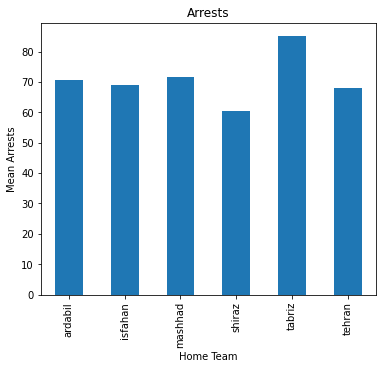

In [384]:
n_words_per_city.plot(kind='bar', title='Arrests', ylabel='Mean Arrests',
                      xlabel='Home Team', figsize=(6, 5))

### Number of sentences  per description

In [385]:
sentence_tokenizer = SentenceTokenizer()

In [386]:
# calculate number of words per description
posts['n_sentences'] = posts.Description.apply(
    lambda desc: len(sentence_tokenizer.tokenize(desc))
)

In [387]:
n_sentences_per_city = posts.groupby(['city'])['n_sentences'].mean()

<AxesSubplot:title={'center':'Arrests'}, xlabel='Home Team', ylabel='Mean Arrests'>

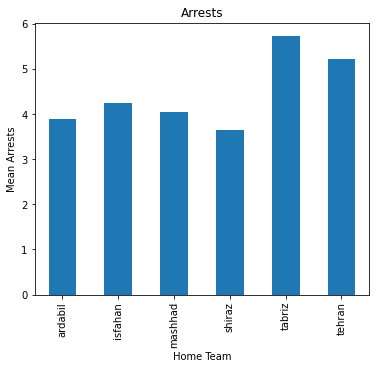

In [388]:
n_sentences_per_city.plot(kind='bar', title='Arrests', ylabel='Mean Arrests',
                          xlabel='Home Team', figsize=(6, 5))

### Most common words

In [389]:
preprocess_pipeline = Pipeline([
    ('t1', RemoveTagTransformer()),
    ('t2', RemoveEmojiesTransformer(column_name='Description')),
    ('t3', DescriptionTransformer(column_name='Description')),
    ('t4', RemoveStopwordsTransformer(column_name='Description'))
])

In [390]:
posts = preprocess_pipeline.fit_transform(posts)

In [391]:
posts.city.value_counts()

ardabil    910
mashhad    456
isfahan    453
shiraz     451
tabriz     450
tehran     449
Name: city, dtype: int64

In [393]:
tehran_posts = posts[posts.city == 'tehran']
tabriz_posts = posts[posts.city == 'tabriz']
isfahan_posts = posts[posts.city == 'isfahan']
mashhad_posts = posts[posts.city == 'mashhad']
ardabil_posts = posts[posts.city == 'ardabil']
shiraz_posts = posts[posts.city == 'shiraz']

In [394]:
all_posts_tokens = [word_tokenize(desc) for desc in tqdm.tqdm(posts.Description)]
tehran_posts_tokens = [word_tokenize(desc) for desc in tqdm.tqdm(tehran_posts.Description)]
tabriz_posts_tokens = [word_tokenize(desc) for desc in tqdm.tqdm(tabriz_posts.Description)]
isfahan_posts_tokens = [word_tokenize(desc) for desc in tqdm.tqdm(isfahan_posts.Description)]
mashhad_posts_tokens = [word_tokenize(desc) for desc in tqdm.tqdm(mashhad_posts.Description)]
ardabil_posts_tokens = [word_tokenize(desc) for desc in tqdm.tqdm(ardabil_posts.Description)]
shiraz_posts_tokens = [word_tokenize(desc) for desc in tqdm.tqdm(shiraz_posts.Description)]

100%|██████████| 451/451 [00:00<00:00, 38696.32it/s]


In [395]:
all_tokens = list(itertools.chain(*all_posts_tokens))
tehran_tokens = list(itertools.chain(*tehran_posts_tokens))
tabriz_tokens = list(itertools.chain(*tabriz_posts_tokens))
isfahan_tokens = list(itertools.chain(*isfahan_posts_tokens))
mashhad_tokens = list(itertools.chain(*mashhad_posts_tokens))
ardabil_tokens = list(itertools.chain(*ardabil_posts_tokens))
shiraz_tokens = list(itertools.chain(*shiraz_posts_tokens))

In [396]:
dataframe = {}

for opt in ['all', 'tehran', 'tabriz', 'isfahan', 'mashhad', 'ardabil', 'shiraz']:
    dataframe[opt] = FreqDist(eval(F"{opt}_tokens")).most_common(50)

freq_analysis = pd.DataFrame(dataframe)

In [397]:
freq_analysis.head(15)

,all,tehran,tabriz,isfahan,mashhad,ardabil,shiraz
0,"(واحد, 2435)","(متر, 276)","(املاک, 515)","(املاک, 356)","(واحد, 259)","(واحد, 799)","(املاک, 364)"
1,"(املاک, 2282)","(واحد, 275)","(واحد, 429)","(واحد, 330)","(عالی, 246)","(املاک, 736)","(واحد, 343)"
2,"(طبقه, 1587)","(منطقه, 222)","(ملک, 297)","(عالی, 261)","(خواب, 202)","(طبقه, 596)","(عالی, 222)"
3,"(عالی, 1470)","(سالن, 213)","(دارا, 280)","(طبقه, 240)","(دیوار, 199)","(تماس, 448)","(خواب, 182)"
4,"(تماس, 1340)","(خواب, 212)","(فروش, 277)","(نور, 238)","(کابینت, 192)","(عالی, 398)","(نقشه, 167)"
5,"(متر, 1219)","(عالی, 201)","(طبقه, 252)","(تماس, 223)","(طبقه, 190)","(متر, 387)","(آپارتمان, 163)"
6,"(خواب, 1165)","(طبقه, 196)","(آدرس, 233)","(پارکینگ, 185)","(املاک, 190)","(دارا, 355)","(تماس, 162)"
7,"(دارا, 1134)","(پارکینگ, 187)","(تماس, 210)","(خواب, 182)","(متری, 163)","(آپارتمان, 354)","(سالن, 161)"
8,"(ملک, 1131)","(نقشه, 184)","(دیوار, 197)","(آپارتمان, 181)","(سرامیک, 159)","(فروش, 341)","(سند, 160)"
9,"(آپارتمان, 1092)","(نور, 163)","(سند, 194)","(متر, 167)","(کف, 158)","(پارکینگ, 338)","(جنوبی, 148)"
